In [370]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats
import h5py
from mpl_toolkits import mplot3d

from cca.synth_data import embedded_lorenz_cross_cov_mats, oscillators_dynamics_mat, oscillators_cross_cov_mats, sample_oscillators
from cca import style, ComplexityComponentsAnalysis

import cca.synth_data

In [483]:
def gen_heatmap(cross_cov_mats, N_theta=100, V=None):
    N_phi = N_theta
    theta = np.concatenate((np.linspace(0, np.pi*(1. - 1./N_theta), N_theta - 1), [np.pi]))
    phi = np.concatenate((np.linspace(0, np.pi*(1. - 1./N_phi), N_phi - 1), [np.pi]))
    heatmap = np.zeros((N_theta, N_phi))
    if V is not None:
        cross_cov_mats = np.array([V.T.dot(C).dot(V) for C in cross_cov_mats])
    
    def pi_val(theta, phi):
        x = np.cos(phi)*np.sin(theta)
        y = np.sin(phi)*np.sin(theta)
        z = np.cos(theta)
        v = np.array([x, y, z]).reshape((3, 1))
        pi = cca.cov_util.calc_pi_from_cross_cov_mats(cross_cov_mats, proj=v)
        return pi
    
    for theta_idx in range(N_theta):
        for phi_idx in range(N_phi):
            pi = pi_val(theta[theta_idx], phi[phi_idx])
            heatmap[theta_idx, phi_idx] = pi
            
    return heatmap

def find_local_maxima(Z, tol=1e-8):
    peaks = []
    n_i, n_j = Z.shape
    for i in range(n_i):
        for j in range(n_j):
            val = Z[i, j]
            if i not in [0, n_i-1] and j not in [0, n_j-1]:
                #regular case
                patch = Z[i-1:i+2, j-1:j+2].flatten()
                if val > np.max(patch[:4]) + tol and val > np.max(patch[5:]) + tol:
                    peaks.append((i, j))
            else:
                #literal edge case
                if i == 0:
                    if val > np.max(Z[1, :]) + tol:
                        peaks += [(0, j_prime) for j_prime in range(n_j)]
                elif i == n_i-1:
                    if val > np.max(Z[n_i-2, :]) + tol:
                        peaks += [(n_i-1, j_prime) for j_prime in range(n_j)]
                elif j == 0:
                    patch = np.concatenate((Z[i-1:i+2, n_j-1:n_j], Z[i-1:i+2, :2]), axis=1).flatten()
                    if val > np.max(patch[:4]) + tol and val > np.max(patch[5:]) + tol:
                        peaks.append((i, j))
                elif j == n_j-1:
                    patch = np.concatenate((Z[i-1:i+2, n_j-2:n_j], Z[i-1:i+2, 0:1]), axis=1).flatten()
                    if val > np.max(patch[:4]) + tol and val > np.max(patch[5:]) + tol:
                        peaks.append((i, j))
    return peaks

def find_global_maxima(Z, local_maxima=None, tol=1e-8):
    if local_maxima is None:
        local_maxima = find_local_maxima_2d(Z)
    max_val = np.max( [Z[i,j] for (i,j) in local_maxima] )
    peaks = []
    for (i, j) in local_maxima:
        if np.abs(Z[i, j] - max_val) <= tol:
            peaks.append((i, j))
    return peaks


def cca_proj(cov_11, cov_12):
    w = scipy.linalg.eigvalsh(cov_11)
    min_eig = np.min(w)
    eps = 1e-8
    if min_eig < eps:
        cov_11 = cov_11 + np.eye(cov_11.shape[0])*(-min_eig + eps)
    cov_neg_sqrt = np.real(np.linalg.inv(scipy.linalg.sqrtm(cov_11)))
    to_svd = cov_neg_sqrt.dot(cov_12).dot(cov_neg_sqrt)
    U, s, Vt = scipy.linalg.svd(to_svd)
    V = Vt.T
    U = np.dot(cov_neg_sqrt, U)
    V = np.dot(cov_neg_sqrt, V)
    U /= np.sqrt(np.sum(U**2, axis=0))
    V /= np.sqrt(np.sum(V**2, axis=0))
    return U, V

def sfa_proj(cov_11, cov_12):
    w = scipy.linalg.eigvalsh(cov_11)
    min_eig = np.min(w)
    eps = 1e-8
    if min_eig < eps:
        print("HMM")
        cov_11 = cov_11 + np.eye(cov_11.shape[0])*(-min_eig + eps)
    cov_neg_sqrt = np.real(np.linalg.inv(scipy.linalg.sqrtm(cov_11)))
    cov_sym = cov_12 + cov_12.T
    to_pca = cov_neg_sqrt.dot(cov_sym).dot(cov_neg_sqrt)
    w, V = scipy.linalg.eigh(to_pca)
    V = V[:, np.argsort(np.abs(w))[::-1]]
    print("Here")
    V = np.dot(cov_neg_sqrt, V)
    return V

def pca_proj(cov):
    _, V = scipy.linalg.eigh(cov)
    V = V[:, ::-1]
    return V

def dca_proj(cov_11, cov_12, d, n_init=1):
    opt = ComplexityComponentsAnalysis(init="random")
    opt.cross_covs = np.array([cov_11, cov_12.T])
    opt.fit_projection(d=d, n_init=n_init)
    V = opt.coef_
    return V

def quad_mat(A, B, C, D):
    top = np.concatenate((A, B), axis=1)
    bottom = np.concatenate((C, D), axis=1)
    mat = np.concatenate((top, bottom), axis=0)
    return mat

def calc_pi(cov_11, cov_12, U, V):
    proj_cov_11 = U.T.dot(cov_11).dot(U)
    proj_cov_22 = V.T.dot(cov_11).dot(V)
    proj_cov_12 = U.T.dot(cov_12).dot(V)
    proj_cov_21 = proj_cov_12.T
    cov_full = quad_mat(proj_cov_11, proj_cov_12, proj_cov_21, proj_cov_22)
    d1 = np.linalg.slogdet(proj_cov_11)[1]
    d2 = np.linalg.slogdet(proj_cov_22)[1]
    d3 = np.linalg.slogdet(cov_full)[1]
    return 0.5 * (d1 + d2 - d3) / np.log(2) #in BITS!

def mi_vs_dim(cov_11, cov_12, n_init=100):
    N = cov_11.shape[0]
    pi_vals = np.zeros((4, N))
    U_cca, V_cca = cca_proj(cov_11, cov_12)
    V_pca = pca_proj(cov_11)
    V_sfa = sfa_proj(cov_11, cov_12)
    V_trunc = np.eye(cov_11.shape[0])[:, ::-1]
    for i in range(1, N+1):
        print(i)
        pi_cca = calc_pi(cov_11, cov_12, U_cca[:, :i], V_cca[:, :i])
        V_dca = dca_proj(cov_11, cov_12, i, n_init=n_init)
        pi_dca = calc_pi(cov_11, cov_12, V_dca, V_dca)
        pi_pca = calc_pi(cov_11, cov_12, V_pca[:, :i], V_pca[:, :i])
        pi_sfa = calc_pi(cov_11, cov_12, V_sfa[:, :i], V_sfa[:, :i])
        #pi_trunc = calc_pi(cov_11, cov_12, V_trunc[:, :i], V_trunc[:, :i])
        #pi_naive_cca = calc_pi(cov_11, cov_12, U_cca[:, :i], U_cca[:, :i])
        pi_vals[:, i-1] = [pi_cca, pi_dca, pi_sfa, pi_pca] #, pi_naive_cca, pi_trunc]
    labels = ["CCA", "DCA", "SFA", "PCA"]#, "Naïve", "Trunc."]
    return pi_vals, labels


(<matplotlib.axes._axes.Axes at 0x1c3a26f630>,
 <matplotlib.axes._axes.Axes at 0x1c39e54358>)

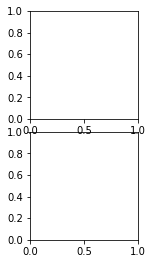

In [520]:
"""
def make_axes(fig_width, n_sq=3, sq_width=0.175, wpad_edge=0, wpad_sq=0.05, wpad_mid=0.05, hpad_edge=0, hpad_mid=0.125):    
    sub_box_width = n_sq*sq_width + (n_sq - 1)*wpad_sq
    right_box_width = 1 - 2*wpad_edge - wpad_mid - sub_box_width
    sq_height = (1 - 2*hpad_edge - hpad_mid)/2
    fig_height = sq_width * fig_width / sq_height
    fig = plt.figure(figsize=(fig_width, fig_height))        
    
    top_squares, bottom_squares = [], []
    for i in range(n_sq):
        ax_top = fig.add_axes((wpad_edge + (sq_width + wpad_sq)*i, hpad_edge + sq_height + hpad_mid, sq_width, sq_height))
        ax_bottom = fig.add_axes((wpad_edge + (sq_width + wpad_sq)*i, hpad_edge, sq_width, sq_height))
        top_squares.append(ax_top)
        bottom_squares.append(ax_bottom)
        
    ax_right_bottom = fig.add_axes(( wpad_edge + sub_box_width + wpad_mid, hpad_edge, right_box_width, sq_height ))
    ax_right_top = fig.add_axes(( wpad_edge + sub_box_width + wpad_mid, hpad_edge + sq_height + hpad_mid, right_box_width, sq_height ))
    
    axes = top_squares + bottom_squares + [ax_right_top, ax_right_bottom]
    for ax in axes:
        ax.set_xticks([])
        ax.set_yticks([])
        
    plt.gcf().text(0, hpad_edge + sq_height + hpad_mid + sq_height/2,
                   "Lorenz Attractor", rotation=90, va="center", ha="left",
                   fontsize=style.axis_label_fontsize, color="black")
    plt.gcf().text(0, hpad_edge + sq_height/2,
                   "Coupled Oscillators", rotation=90, va="center", ha="left",
                   fontsize=style.axis_label_fontsize, color="black")
        
    return top_squares, bottom_squares, ax_right_top, ax_right_bottom
"""
def make_axes(fig_width, wpad_edge=0, hpad_edge=0, hpad_mid=0.125):
    sq_height = (1 - 2*hpad_edge - hpad_mid)/2
    sq_width = 1. - 2*wpad_edge
    fig_height = sq_width * fig_width / sq_height
    fig = plt.figure(figsize=(fig_width, fig_height))        
        
    ax_bottom = fig.add_axes(( wpad_edge, hpad_edge, sq_width, sq_height ))
    ax_top = fig.add_axes(( wpad_edge, hpad_edge + sq_height + hpad_mid, sq_width, sq_height ))
        
    return ax_top, ax_bottom
    
def disp_heatmap(ax, heatmap, show_xlabels=True, show_ylabels=True, title=None, tol=0):
    N_theta, N_phi = heatmap.shape
    im = ax.imshow(heatmap, origin="lower left", cmap="gray", aspect='equal')
    
    local_maxima = find_local_maxima(heatmap, tol=tol)
    global_maxima = find_global_maxima(heatmap, local_maxima, tol=tol)
    non_global_maxima = list(set(local_maxima) - set(global_maxima))
    for pt in global_maxima:
        ax.scatter(pt[1], pt[0], c="red", marker="o", s=15)
    for pt in non_global_maxima:
        ax.scatter(pt[1], pt[0], edgecolors="red", marker="o", facecolors='none', s=15)
    
    if show_xlabels:
        ax.set_xlabel("$\phi$", fontsize=style.axis_label_fontsize, labelpad=-style.axis_label_fontsize)
        ax.set_xticks([0, N_phi-1])
        ax.set_xticklabels(["0", "$\pi$"], fontsize=style.ticklabel_fontsize)
    else:
        ax.set_xticks([])
    if show_ylabels:
        ax.set_ylabel("$\\theta$", fontsize=style.axis_label_fontsize, labelpad=-style.axis_label_fontsize)
        ax.set_yticks([0, N_theta-1])
        ax.set_yticklabels(["0", "$\pi$"], fontsize=style.ticklabel_fontsize)
    else:
        ax.set_yticks([])
    ax.set_xlim([0, heatmap.shape[1]-1])
    ax.set_ylim([0, heatmap.shape[0]-1])
    if title is not None:
        ax.set_title(title, fontsize=style.axis_label_fontsize)

def cycle_from_style(scheme):
    return [color_dict["color"] for color_dict in plt.style.library[scheme]['axes.prop_cycle']]

method_colors = ["black", "red", "coral", "gray"]
def plot_mi_vs_dim(mi_vals, labels, ax=None, legend=False, xlabel=False):
    if ax is None:
        fig, ax = plt.subplots(1, 1, figsize=(5, 3))
    num_methods, N = mi_vals.shape
    pi_retained = np.concatenate((mi_vals[:, ::-1], np.zeros(num_methods).reshape((num_methods, 1))), axis=1)
    dims_dropped = np.arange(N + 1)
    max_mi = np.max(mi_vals)
    
    diag_x_vals = np.linspace(-1, N+1, 100)
    diag_y_vals = -(max_mi / N)*diag_x_vals + max_mi
    ax.plot(diag_x_vals, diag_y_vals, c="black", linestyle="--", linewidth=1)
    ypad = 0.05 * max_mi
    ax.set_xlim([0, N])
    ax.set_ylim([0, max_mi*1.05])
    
    xticks = [0, 5, 10, 15, 20]
    ax.set_xticks(xticks)
    ax.set_xticklabels(xticks, fontsize=style.ticklabel_fontsize)
    
    yticks = [0, np.round(max_mi, 1)]
    max_ylabel = str(yticks[-1])
    while len(max_ylabel) < 4:
        print("SADASD")
        max_ylabel = "  " + max_ylabel
    ytick_labels = [str(yticks[0]), max_ylabel]
    ax.set_yticks(yticks)
    ax.set_yticklabels(ytick_labels, fontsize=style.ticklabel_fontsize)
    ax.tick_params(axis='y', which='major', pad=1)
    
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['left'].set_bounds(0, max_mi)

    
    #colors = cycle_from_style("tableau-colorblind10")
    #colors = ["black", "gray", "green", "blue", "red", "purple"]
    for i in range(num_methods):
        linewidth = 1 if labels[i] == "CCA" else 0.75
        markersize = 3 if labels[i] == "CCA" else 2
        ax.plot(dims_dropped, pi_retained[i], label=labels[i], linewidth=linewidth,
                color=method_colors[i], marker=".", markersize=markersize)
        
    if legend:
        ax.legend(loc="lower left", fontsize=style.axis_label_fontsize, frameon=False)
                  #ncol=1, labelspacing=0.1, columnspacing=0.6,
                  #bbox_to_anchor=(0.05, 0.0, 1, 1))
        
    if xlabel:
        ax.set_xlabel("dimensions dropped", fontsize=style.axis_label_fontsize)
        
        
    ax.set_ylabel("MI [bits]", fontsize=style.axis_label_fontsize, labelpad=-style.axis_label_fontsize/2)
        
        
#make_axes(5.5, n_sq=3, sq_width=0.175, wpad_sq=0.05, wpad_edge=0.05)
make_axes(1.5, wpad_edge=0, hpad_edge=0.05, hpad_mid=0.05)




In [384]:
#Get cross-cov mats for all systems

#Lorenz system
lorenz_cross_cov_mats = embedded_lorenz_cross_cov_mats(N=30, T=20, snr=1.)

#Oscillator system (10 oscillators --> 20-dimensional state)
A = oscillators_dynamics_mat(N=10)
osc_cross_cov_mats = oscillators_cross_cov_mats(A, T=20)

(30, 27)


In [491]:
#Run the 'MI vs. dimensionality' analysis for the Lorenz and oscillator systems
pi_lorenz, labels = mi_vs_dim(lorenz_cross_cov_mats[0], lorenz_cross_cov_mats[10].T, n_init=1)
pi_osc, _ = mi_vs_dim(osc_cross_cov_mats[0], osc_cross_cov_mats[10].T, n_init=1)

"""
#Get 3-dim DCA subspaces for Tpi=1 for both systemsopt = ComplexityComponentsAnalysis(init="random")
n_init = 1
opt = ComplexityComponentsAnalysis(init="random")
opt.cross_covs = lorenz_cross_cov_mats[:10]
opt.fit_projection(d=3, n_init=n_init)
V_dca_lorenz = opt.coef_
opt.cross_covs = osc_cross_cov_mats[:10]
opt.fit_projection(d=3, n_init=n_init)
V_dca_osc = opt.coef_
"""

Here
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
Here
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20


'\n#Get 3-dim DCA subspaces for Tpi=1 for both systemsopt = ComplexityComponentsAnalysis(init="random")\nn_init = 1\nopt = ComplexityComponentsAnalysis(init="random")\nopt.cross_covs = lorenz_cross_cov_mats[:10]\nopt.fit_projection(d=3, n_init=n_init)\nV_dca_lorenz = opt.coef_\nopt.cross_covs = osc_cross_cov_mats[:10]\nopt.fit_projection(d=3, n_init=n_init)\nV_dca_osc = opt.coef_\n'

In [492]:
"""
#Get heatmaps for both systems, projected into their d=3 DCA subspaces
N_theta = 20
T_pi_vals = np.array([1, 2])
lorenz_heatmaps = np.zeros((len(T_pi_vals), N_theta, N_theta))
osc_heatmaps = np.zeros_like(lorenz_heatmaps)
for T_pi_idx in range(len(T_pi_vals)):
    T_pi = T_pi_vals[T_pi_idx]
    lorenz_heatmaps[T_pi_idx] = gen_heatmap(lorenz_cross_cov_mats[:2*T_pi], N_theta=N_theta, V=V_dca_lorenz)
    osc_heatmaps[T_pi_idx] = gen_heatmap(osc_cross_cov_mats[:2*T_pi], N_theta=N_theta, V=V_dca_osc)
"""

SADASD


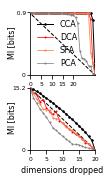

In [525]:
"""
top_squares, bottom_squares, ax_right_top, ax_right_bottom = make_axes(5.5, n_sq=len(T_pi_vals),
                                                                       sq_width=0.15, wpad_edge=0.07, wpad_sq=0.05,
                                                                       wpad_mid=0.1, hpad_mid=0.14, hpad_edge=0.14)
#Find local minima and plot
tol = 0
for T_pi_idx in range(len(T_pi_vals)):
    ax_top, ax_bottom = top_squares[T_pi_idx], bottom_squares[T_pi_idx]
    disp_heatmap(ax_top, lorenz_heatmaps[T_pi_idx], title="$T="+str(T_pi_vals[T_pi_idx])+"$", tol=tol)
    disp_heatmap(ax_bottom, osc_heatmaps[T_pi_idx], tol=tol)
    
#Make MI vs. dim curves
plot_mi_vs_dim(pi_lorenz, labels, ax_right_top)
plot_mi_vs_dim(pi_osc, labels, ax_right_bottom, legend=True, xlabel=True)

    
plt.savefig("figures/local_minima_test.pdf")#, bbox_inches="tight")
"""

ax_top, ax_bottom = make_axes(1.5, wpad_edge=.2, hpad_edge=0.15, hpad_mid=0.05)
plot_mi_vs_dim(pi_lorenz, labels, ax_top, legend=True)
plot_mi_vs_dim(pi_osc, labels, ax_bottom, xlabel=True)

plt.savefig("figures/local_minima_test.pdf")#, bbox_inches="tight")
